# Метод, основанный на использовании слов закрытых грамматичесикх классов и структурных триграмм

## Загрузка необходимых модулей

In [2]:
import re
import pandas as pd
import pymorphy2
import nltk
import tqdm 

morph = pymorphy2.MorphAnalyzer()

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

def syntax_encode(text):
    text = text.lower()
    text = re.findall('\w+|\.\.\.|\!\?|[:\-,\.;\(\)\!\?]', text)
    result = []
    for token in text:
        pos = str(morph.parse(token)[0].tag.POS or morph.parse(token)[0].tag)
        if pos == 'PNCT':
            result.append(token)
            continue 
        result.append(pos)
    return result

def tokenize(text):
    res = []
    for sent in nltk.sent_tokenize(text):
        t = syntax_encode(sent)
        s = nltk.ngrams(t, 3)
        res += s
    return res

vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize, max_features=1000, min_df=5, max_df=0.7)

In [4]:
with open('../data/functional_words/vvodn') as f:
    VVODN_LIST = f.read().split()  # список вводных слов русского языка

with open('../data/functional_words/souz') as f:
    SOUZ_LIST = f.read().split() # список союзов русского языка

with open('../data/functional_words/chast') as f:
    CHAST_LIST = f.read().split()  #  список частиц русского языка

with open('../data/functional_words/judge') as f:
    JUDGE_LIST = f.read().split()  # список оценочных слов русского языка

def vectorize(text):
    text = re.findall('[а-яё]+', text.lower())
    vvodn = dict.fromkeys(VVODN_LIST, 0)
    souz = dict.fromkeys(SOUZ_LIST, 0)
    chast = dict.fromkeys(CHAST_LIST, 0)
    judge = dict.fromkeys(JUDGE_LIST, 0)
    for word in text:
        if word in vvodn:
            vvodn[word] += 1
        if word in souz:
            souz[word] += 1
        if word in chast:
            chast[word] += 1
        if morph.parse(word)[0].normal_form in judge:
            judge[morph.parse(word)[0].normal_form] += 1

    res = []
    for key in sorted(vvodn):
        res.append(vvodn[key] / max(1, sum(vvodn.values())))
    for key in sorted(souz):
        res.append(souz[key] / max(1, sum(souz.values())))
    for key in sorted(chast):
        res.append(chast[key] / max(1, sum(chast.values())))
    for key in sorted(judge):
        res.append(judge[key] / max(1, sum(judge.values())))

    return res

## Загрузка тренировочного и тестового датасета

In [5]:
train_df = pd.read_csv('../datasets/russian_classics/train_4_10_1000.csv') 
print(train_df.shape)
test_df = pd.read_csv('../datasets/russian_classics/test_4_40_600.csv') 
print(test_df.shape)

(40, 4)
(160, 4)


## Предобработка текстов

In [6]:
from tqdm import tqdm

train_texts = train_df['Content']
test_texts = test_df['Content']

In [7]:
train_X, train_y = list(train_texts), [int(a) for a in train_df['Author']]
test_X, test_y = list(test_texts), [int(a) for a in test_df['Author']]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange

all_texts = list(train_texts) + list(test_texts)
y = train_y + test_y

tfidfconverter = vectorizer
X = tfidfconverter.fit_transform(all_texts).toarray()
X1 = []
for i in range(len(y)):
    X1.append(list(X[i]) + vectorize(all_texts[i]))

X = X1

X_train, X_test, y_train, y_test = X[:len(train_y)], X[len(train_y):], train_y, test_y


100%|██████████| 28/28 [00:00<00:00, 154.46it/s]


## Построение деревьев решений

In [9]:
classifier = RandomForestClassifier(n_estimators=2000, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Результат

In [10]:
y_pred = classifier.predict(X_test)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[27  4  5  4]
 [ 0 40  0  0]
 [ 3  6 29  2]
 [ 1  6  3 30]]
              precision    recall  f1-score   support

           0       0.87      0.68      0.76        40
           1       0.71      1.00      0.83        40
           2       0.78      0.72      0.75        40
           3       0.83      0.75      0.79        40

    accuracy                           0.79       160
   macro avg       0.80      0.79      0.78       160
weighted avg       0.80      0.79      0.78       160

0.7875


## Исследование важности определнных слов закрытых классов

In [67]:
features =  VVODN_LIST + SOUZ_LIST + CHAST_LIST + JUDGE_LIST
f_i = dict(zip(features, classifier.feature_importances_[-401:]))

In [16]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

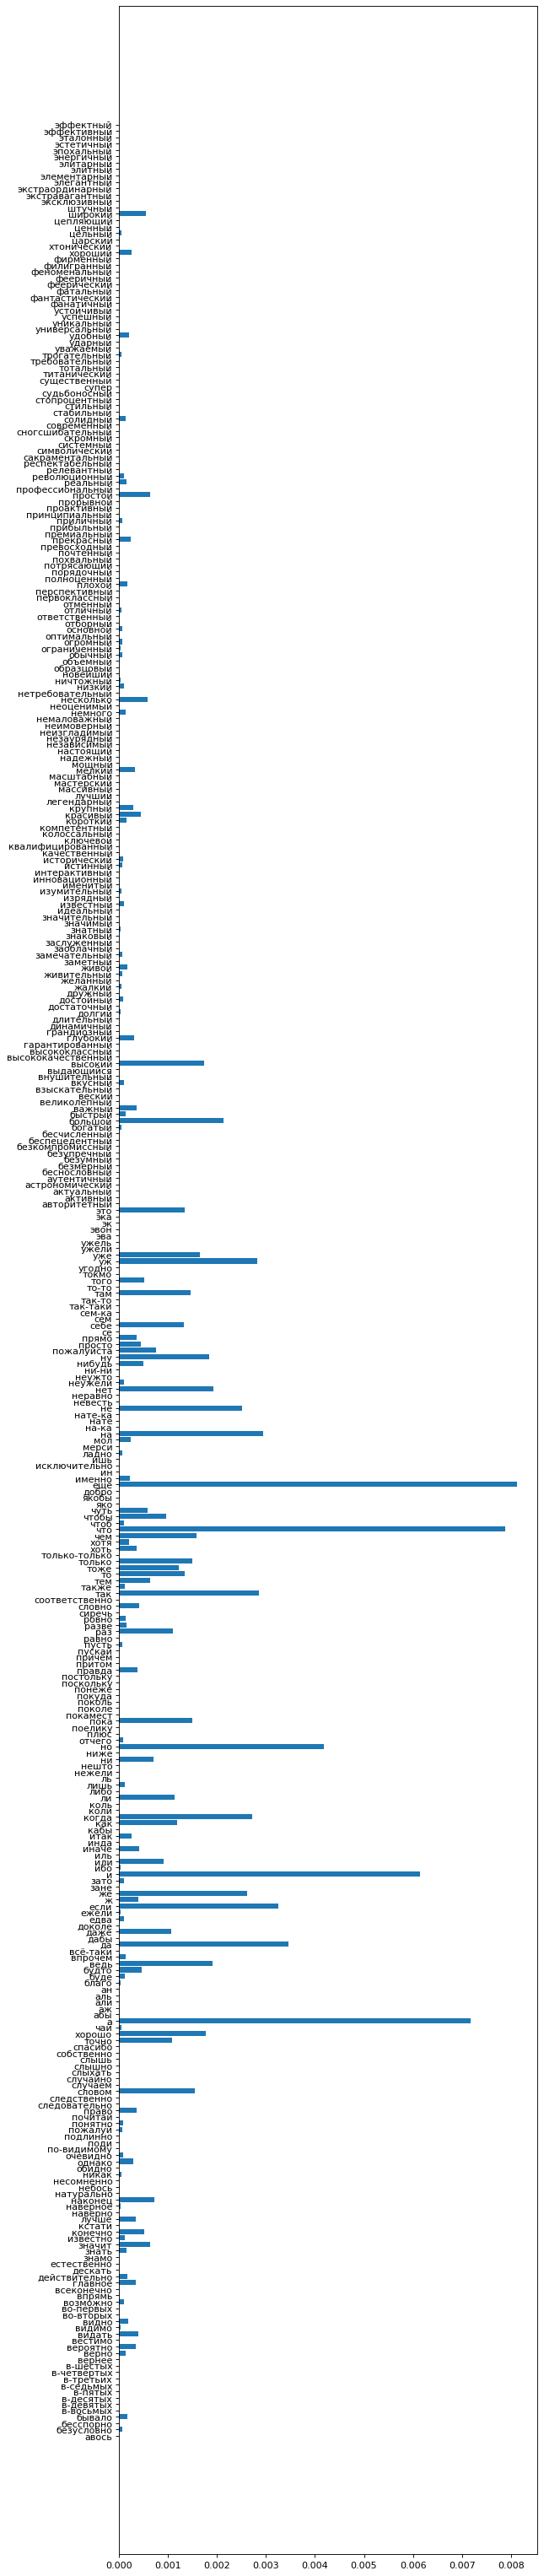

In [17]:
figure(figsize=(8, 50), dpi=80)

plt.barh(list(f_i.keys()), list(f_i.values()))
plt.show()

## Проверка метода на других датасетах

In [43]:
def test_method(train_datasets: list, test_datasets: list, predict_func):
    for d_test in test_datasets:
        for d_train in train_datasets:
            print("Test: {}, train: {}: {}".format(d_test, d_train, predict_func(d_test, d_train)))
    

In [50]:
def predict(test_dataset, train_dataset):
    train_df = pd.read_csv(train_dataset)
    test_df = pd.read_csv(test_dataset)
    train_texts = train_df['Content']
    test_texts = test_df['Content']
    train_X, train_y = list(train_texts), [int(a) for a in train_df['Author']]
    test_X, test_y = list(test_texts), [int(a) for a in test_df['Author']]
    all_texts = list(train_texts) + list(test_texts)
    y = train_y + test_y

    tfidfconverter = vectorizer
    X = tfidfconverter.fit_transform(all_texts).toarray()
    X1 = []
    for i in range(len(y)):
        X1.append(list(X[i]) + vectorize(all_texts[i]))

    X = X1
    X_train, X_test, y_train, y_test = X[:len(train_y)], X[len(train_y):], train_y, test_y

    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 

    y_pred = classifier.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [51]:
train_datasets = [
    '../datasets/russian_classics/train_4_5_600.csv',
    '../datasets/russian_classics/train_4_10_1000.csv'
]

test_datasets = [
    '../datasets/russian_classics/test_4_40_600.csv'
]

In [52]:
test_method(train_datasets, test_datasets, predict)

Test: ../datasets/russian_classics/test_4_40_600.csv, train: ../datasets/russian_classics/train_4_5_600.csv: 0.65
Test: ../datasets/russian_classics/test_4_40_600.csv, train: ../datasets/russian_classics/train_4_10_1000.csv: 0.76875


In [54]:
train_datasets = [
    '../datasets/russian_classics/train_23_5_600.csv',
    '../datasets/russian_classics/train_23_10_1000.csv'
]

test_datasets = [
    '../datasets/russian_classics/test_23_40_600.csv'
]

In [55]:
test_method(train_datasets, test_datasets, predict)

Test: ../datasets/russian_classics/test_23_40_600.csv, train: ../datasets/russian_classics/train_23_5_600.csv: 0.35877862595419846
Test: ../datasets/russian_classics/test_23_40_600.csv, train: ../datasets/russian_classics/train_23_10_1000.csv: 0.4351145038167939


In [63]:
train_datasets = [
    '../datasets/russian_classics/train_23_5_600.csv',
    '../datasets/russian_classics/train_23_10_1000.csv'
]

test_datasets = [
    '../datasets/russian_classics/test_23_40_1000.csv'
]

In [64]:
test_method(train_datasets, test_datasets, predict)

Test: ../datasets/russian_classics/test_23_40_1000.csv, train: ../datasets/russian_classics/train_23_5_600.csv: 0.3845278725824801
Test: ../datasets/russian_classics/test_23_40_1000.csv, train: ../datasets/russian_classics/train_23_10_1000.csv: 0.5506257110352674


In [65]:
train_datasets = [
    '../datasets/proza_ru/proza_train.csv',
]

test_datasets = [
    '../datasets/proza_ru/proza_test.csv'
]

In [66]:
test_method(train_datasets, test_datasets, predict)

Test: ../datasets/proza_ru/proza_test.csv, train: ../datasets/proza_ru/proza_train.csv: 0.8853754940711462
